In [7]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns

# Read all results

In [8]:
models = ["ResNet", "ViT"]
datasets = ["CIFAR10", "CIFAR100", "FOOD101"]
methods = {"dvi":"DVI", "timevis":"TimeVis", "tdvi":"SentryCam"}
k_neighbors = [15]

selected_epochs_dict = {"CIFAR10":[1, 100, 200],"CIFAR100":[1, 100, 200], "FOOD101":[1,10, 20]}
col = np.array(["dataset", "method", "type", "hue", "k", "period", "eval", "model"])

In [9]:
df = pd.DataFrame({}, columns=col)

for i in range(len(datasets)): # dataset
    dataset = datasets[i]
    for model in models:    # model
        data = np.array([])
        selected_epochs = selected_epochs_dict[dataset]
        for method in methods.keys():   # method
            eval_path = f"/home/yangxl21/DVI_data/{model}_{dataset}/Model/evaluation_{method}.json"
            with open(eval_path, "r") as f:
                    eval = json.load(f)
            for k in k_neighbors: # k neighbors
                for stage in range(len(selected_epochs)):
                    epoch = selected_epochs[stage]
                    nn_train = round(eval["trustworthiness_train"][str(epoch)][str(k)], 3)
                    nn_test = round(eval["trustworthiness_test"][str(epoch)][str(k)], 3)

                    if len(data) == 0:
                        data = np.array([[dataset, f"{methods[method]}", "Train", f"{methods[method]}(Train)", "{}".format(k), "{}".format(str(stage)), nn_train, model]])
                    else:
                        data = np.concatenate((data, np.array([[dataset, f"{methods[method]}", "Train", f"{methods[method]}(Train)", "{}".format(k), "{}".format(str(stage)), nn_train, model]])), axis=0)
                    data = np.concatenate((data, np.array([[dataset, f"{methods[method]}", "Test", f"{methods[method]}(Test)", "{}".format(k), "{}".format(str(stage)), nn_test, model]])), axis=0)

        df_tmp = pd.DataFrame(data, columns=col)
        df = df.append(df_tmp, ignore_index=True)
        df[["period"]] = df[["period"]].astype(int)
        df[["k"]] = df[["k"]].astype(int)
        df[["eval"]] = df[["eval"]].astype(float)

/tmp/ipykernel_50770/825042902.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_tmp, ignore_index=True)
/tmp/ipykernel_50770/825042902.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_tmp, ignore_index=True)
/tmp/ipykernel_50770/825042902.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_tmp, ignore_index=True)
/tmp/ipykernel_50770/825042902.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_tmp, ignore_index=True)
/tmp/ipykernel_50770/825042902.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

# Plot

In [10]:
k = k_neighbors[0]
model = "ViT"

In [11]:
df_tmp = df[df["k"] == k]
df_tmp = df[df["model"] == model]

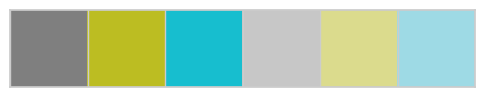

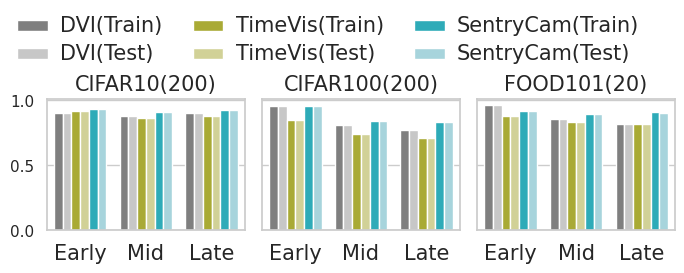

In [12]:
pal20c = sns.color_palette('tab20', 20)
sns.set_theme(style="whitegrid", palette=pal20c)
hue_dict = {
    "DVI(Train)": pal20c[14],
    "TimeVis(Train)": pal20c[16],
    "SentryCam(Train)": pal20c[18],

    "DVI(Test)": pal20c[15],
    "TimeVis(Test)": pal20c[17],
    "SentryCam(Test)": pal20c[19],
}
sns.palplot([hue_dict[i] for i in hue_dict.keys()])

axes = {'labelsize': 15,
        'titlesize': 15,}
mpl.rc('axes', **axes)
mpl.rcParams['xtick.labelsize'] = 15

hue_list = ["DVI(Train)", "DVI(Test)", "TimeVis(Train)", "TimeVis(Test)", "SentryCam(Train)", "SentryCam(Test)"]

fg = sns.catplot(
    x="period",
    y="eval",
    hue="hue",
    hue_order=hue_list,
    # order = [1, 2, 3, 4, 5],
    # row="method",
    col="dataset",
    errorbar=('ci', 0.001),
    height=2.5, #2.65,
    aspect=1.0,#3,
    data=df_tmp,
    kind="bar",
    palette=[hue_dict[i] for i in hue_list],
    legend=True
)
sns.move_legend(fg, "lower center", bbox_to_anchor=(.42, 0.92), ncol=3, title=None, frameon=False)
mpl.pyplot.setp(fg._legend.get_texts(), fontsize='15')

axs = fg.axes[0]
# max_ = df_tmp["eval"].max()
# min_ = df["eval"].min()
# axs[0].set_ylim(0., max_*1.1)
axs[0].set_title("CIFAR10(200)")
axs[1].set_title("CIFAR100(200)")
axs[2].set_title("FOOD101(20)")

(fg.despine(bottom=False, right=False, left=False, top=False)
    .set_xticklabels(['Early', 'Mid', 'Late'])
    .set_axis_labels("", "")
    )
# fg.fig.suptitle("NN preserving property")
fg.savefig(
    f"./plot_results/trustworthiness_{model}_{k}.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.0,
    # transparent=True,
)